In [34]:
from bs4 import BeautifulSoup
import requests
import tqdm
from matplotlib import pyplot as plt
import sys
import numpy as np

In [5]:
url = "https://sparse.tamu.edu/?page="
num_pages = 145  # Starting from 1

# Load all num_rows, num_cols, and num_nonzeros from all matrices as well as their ids and year.

In [16]:
matrix_list = []
# matrix is stored in shape of (id, rows, cols, nnz, year)

# The website has a table and each entry is a matrix. For each matrix we append the values of the td's with the classnames:
# column-id, column-num_rows, column-num_cols, column-nonzeros, column-date d-none d-md-table-cell
for i in tqdm.tqdm(range(1, num_pages)):
    page = url + str(i)
    # Get the page
    page = requests.get(page)
    soup = BeautifulSoup(page.content, "html.parser")
    table = soup.find("table", {"class": "table table-sm table-striped"})
    for row in table.find_all("tr"):
        col_id = row.find("td", {"class": "column-id"})
        col_rows = row.find("td", {"class": "column-num_rows"})
        col_cols = row.find("td", {"class": "column-num_cols"})
        col_nnz = row.find("td", {"class": "column-nonzeros"})
        col_date = row.find("td", {"class": "column-date d-none d-md-table-cell"})
        if col_id is not None:
            matrix_list.append(
                (
                    col_id.text,
                    col_rows.text,
                    col_cols.text,
                    col_nnz.text,
                    col_date.text,
                )
            )

100%|██████████| 144/144 [01:30<00:00,  1.59it/s]


In [33]:
print(f"Size of matrix list: {len(matrix_list)}")

Size of matrix list: 2880


In [48]:
# convert the list to a numpy array
matrix_list_np = np.array(matrix_list)
# for all items remove the commas and convert to int
matrix_list_np[:, 1:4] = np.char.replace(matrix_list_np[:, 1:4], ",", "")
# replace the empty strings with nan
matrix_list_np[matrix_list_np == ""] = np.nan
matrix_list_np[:, 1:4] = matrix_list_np[:, 1:4].astype(int)

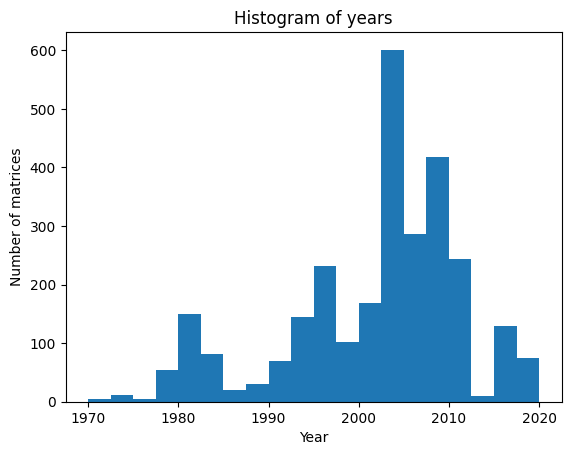

In [50]:
# Make a histogram of the years, excluding the nan values
corrected_years = matrix_list_np[:, 4][~np.isnan(matrix_list_np[:, 4].astype(float))]
plt.hist(corrected_years.astype(int), bins=20)
plt.title("Histogram of years")
plt.xlabel("Year")
plt.ylabel("Number of matrices")
plt.show()

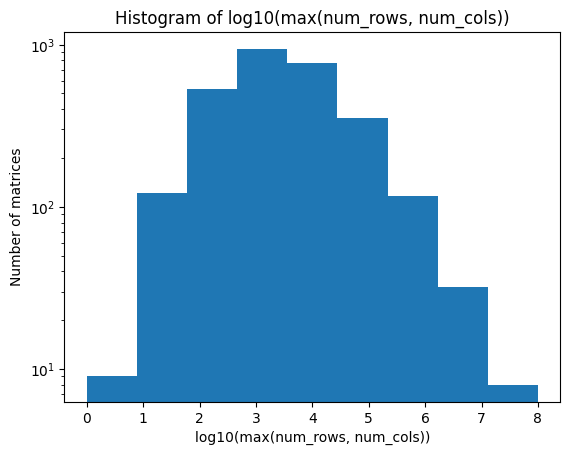

In [63]:
# make a logarithmic histogram of max(num_rows, num_cols) of the matrices
max_rows_cols = np.maximum(
    matrix_list_np[:, 1].astype(int), matrix_list_np[:, 2].astype(int)
)
log_max_rows_cols = np.log10(max_rows_cols)
plt.hist(log_max_rows_cols.astype(int), bins=9, log=True)
plt.title("Histogram of log10(max(num_rows, num_cols))")
plt.xlabel("log10(max(num_rows, num_cols))")
plt.ylabel("Number of matrices")
plt.show()

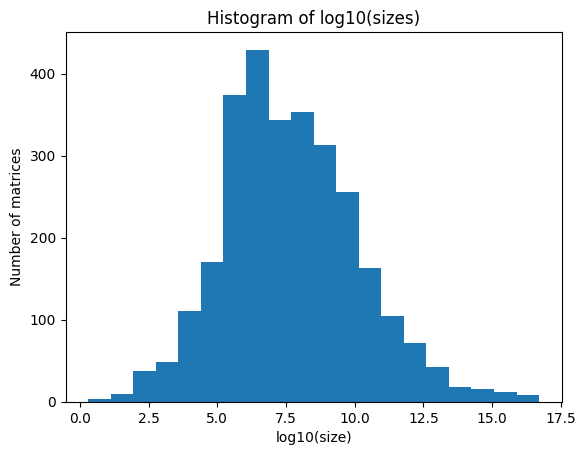

In [53]:
# make a logarithmic histogram of the sizes of the matrices
sizes = matrix_list_np[:, 1].astype(int) * matrix_list_np[:, 2].astype(int)
log_sizes = np.log10(sizes)
plt.hist(log_sizes, bins=20)
plt.title("Histogram of log10(sizes)")
plt.xlabel("log10(size)")
plt.ylabel("Number of matrices")
plt.show()

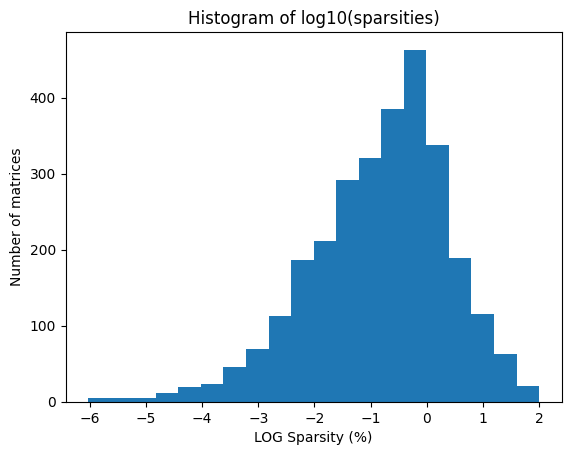

In [55]:
# make a histogram of the sparsities of the matrices. eg. nnz / sizes
sparsities = matrix_list_np[:, 3].astype(int) / sizes * 100
log_sparsities = np.log10(sparsities)
plt.hist(log_sparsities, bins=20)
plt.title("Histogram of log10(sparsities)")
plt.xlabel("LOG Sparsity (%)")
plt.ylabel("Number of matrices")
plt.show()

In [58]:
print(
    f"Number of matrices with sparsity < 5%: {np.sum(sparsities < 5)}, in percentage: {np.sum(sparsities < 5) / len(sparsities) * 100} %"
)
print(
    f"Number of matrices with sparsity < 1%: {np.sum(sparsities < 1)}, in percentage: {np.sum(sparsities < 1) / len(sparsities) * 100} %"
)
print(
    f"Number of matrices with sparsity < 0.1%: {np.sum(sparsities < 0.1)}, in percentage: {np.sum(sparsities < 0.1) / len(sparsities) * 100} %"
)

Number of matrices with sparsity < 5%: 2637, in percentage: 91.5625 %
Number of matrices with sparsity < 1%: 2175, in percentage: 75.52083333333334 %
Number of matrices with sparsity < 0.1%: 1144, in percentage: 39.72222222222222 %


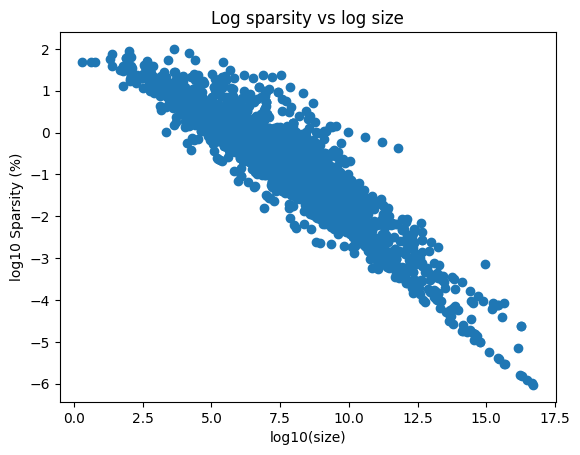

In [65]:
# Plot log sparity vs log size
plt.scatter(log_sizes, log_sparsities)
plt.title("Log sparsity vs log size")
plt.xlabel("log10(size)")
plt.ylabel("log10 Sparsity (%)")
plt.show()